# Delaunay triangulation and Voronoi diagrams

This notebook contains programme computing delaunay triangulation for given set of points, dual graph to the triangulation and finally voronoi diagrams bounded by a box containing the result.

The algorithm is based on "Computational Geometry Algorithms and Applications" by M. de Berg, O. Cheong, M van Kreveld and M Overmars, sections. 9.1 - 9.3, p. 193 - 205.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

#just for computation time
import time

## The algorithm

### Auxiliary functions

Computing determinant to determine orientation of 3 points on the plane. Far points are took into account.

In [2]:
def det(a, b, c):
    """Compute determinant between 3 points to find their orientation."""
    
    # Deal with situation when exactly 2 of the 3 points are far points.
    if     isinstance(a, FarPoint) and     isinstance(b, FarPoint) and not isinstance(c, FarPoint):
        if a.side == 'r' and b.side == 'l':
            return -1
        else:
            return 1
    if     isinstance(a, FarPoint) and not isinstance(b, FarPoint) and     isinstance(c, FarPoint):
        if a.side == 'r' and c.side == 'l':
            return 1
        else:
            return -1
    if not isinstance(a, FarPoint) and     isinstance(b, FarPoint) and     isinstance(c, FarPoint):
        if b.side == 'r' and c.side == 'l':
            return -1
        else:
            return 1
    
    # Deal with situation when exactly 1 of the 3 points is a far point.
    if isinstance(a, FarPoint):
        if a.side == 'r':
            return 1 if b[1] > c[1] else -1
        else:
            return 1 if b[1] < c[1] else -1
    if isinstance(b, FarPoint):
        if b.side == 'r':
            return 1 if a[1] < c[1] else -1
        else:
            return 1 if a[1] > c[1] else -1
    if isinstance(c, FarPoint):
        if c.side == 'r':
            return 1 if a[1] > b[1] else -1
        else:
            return 1 if a[1] < b[1] else -1
    
    # Deal with the rest - 3 ordinary points.
    ax, ay = a
    bx, by = b
    cx, cy = c
    
    return ax*by*1.0 + bx*cy*1.0 + cx*ay*1.0 - 1.0*by*cx - 1.0*cy*ax - 1.0*ay*bx

In [3]:
def intersect(a, b, c, d):
    """Find out whether segments (a, b) and (c, d) intersect."""
    
    d1 = det(c, d, a)
    d2 = det(c, d, b)
    d3 = det(a, b, c)
    d4 = det(a, b, d)
    
    if (    ( (d1>0 and d2<0) or (d1<0 and d2>0) )
        and ( (d3>0 and d4<0) or (d3<0 and d4>0) )):
        return True
    return False

def intersection(a, b, c, d):
    """Compute intersection point of (a, b) and (c, d)."""
    
    v1x = b[0] - a[0]
    v1y = b[1] - a[1]
    v2x = d[0] - c[0]
    v2y = d[1] - c[1]
    
    W = v1x*v2y - v1y*v2x
    Wt = (c[0] - a[0])*v2y - (c[1] - a[1])*v2x
    t = Wt/W
    
    return (a[0] + v1x*t, a[1] + v1y*t)

### Dual Graph

In [4]:
def border_line(vertex, start, end, third_point, borders, maxi_len):
    """Compute segment starting in vertex and going outside the triangle to a side of bounding box."""
    
    v = end[0] - start[0], end[1] - start[1]
    
    if det(start, end, third_point) > 0:
        v = v[1], -v[0]
    else:
        v = -v[1], v[0]

    v_len = np.sqrt(v[0]**2 + v[1]**2)
    v = v[0]/v_len*maxi_len, v[1]/v_len*maxi_len
    
    outside = vertex[0] + v[0], vertex[1] + v[1]
    
    for border in borders:
        if intersect(vertex, outside, border[0], border[1]):
            return vertex, intersection(vertex, outside, border[0], border[1])

In [5]:
def make_dual_graph(T):
    """Compute dual graph.
    
    T: list of Triangles
    """
    
    triangles = T.copy()
    points = [point for triangle in triangles for point in triangle.points]
    
    # Find box containing all triangles.
    max_x = max(points, key=lambda p: p[0])[0]
    min_x = min(points, key=lambda p: p[0])[0]
    max_y = max(points, key=lambda p: p[1])[1]
    min_y = min(points, key=lambda p: p[1])[1]
    
    x_range = max_x - min_x
    y_range = max_y - min_y
    maxi_len = max(x_range, y_range)
    
    max_x += x_range * 0.25
    min_x -= x_range * 0.25
    max_y += y_range * 0.25
    min_y -= y_range * 0.25
    
    # making the box a square
    max_x = max_y = max(max_x, max_y)
    min_x = min_y = min(min_x, min_y)
    
    # Compute lines bounding the box.
    plb, prb, prt, plt = (min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y)
    lines = [(plb, prb), (prb, prt), (prt, plt), (plt, plb)]
    borders = lines.copy()
    
    # Filter out neighbors containing far points.
    for triangle in triangles:
        filtered = list()
        for neighbor in triangle.neighbors:
            np1, np2, np3 = tuple(neighbor.points)
            if isinstance(np1, FarPoint) or isinstance(np2, FarPoint) or isinstance(np3, FarPoint):
                continue
            filtered.append(neighbor)
        triangle.neighbors = filtered
    
    # edges without neighbors
    for triangle in triangles:
        p1, p2, p3 = tuple(triangle.points)
        vertex = circle_center(p1, p2, p3)
        
        # Filter out points outsite the box.
        if any([det(border[0], border[1], vertex) < 0 for border in borders]):
            continue
        
        # Connect centers of circles described on neighboring triangles.
        for neighbor in triangle.neighbors:
            np1, np2, np3 = tuple(neighbor.points)
            neighbor_vertex = circle_center(np1, np2, np3)
            added = False
            for border in borders:
                if intersect(vertex, neighbor_vertex, border[0], border[1]):
                    lines.append((vertex, intersection(vertex, neighbor_vertex, border[0], border[1])))
                    added = True
            if not added:
                lines.append((vertex, neighbor_vertex))

        # Deal with circle centers outside the box.
        if len(triangle.neighbors) == 2:
            common_point = (triangle.neighbors[0].points & triangle.neighbors[1].points).pop()
            edge = (triangle.points - {common_point})
            p1, p2 = edge.pop(), edge.pop()
            
            lines.append(border_line(vertex, p1, p2, common_point, borders, maxi_len))
        
        if len(triangle.neighbors) == 1:
            single_point = (triangle.points - triangle.neighbors[0].points).pop()
            two_rest_points = (triangle.points - {single_point})
            p1, p2 = two_rest_points.pop(), two_rest_points.pop()
            
            lines.append(border_line(vertex, single_point, p1, p2, borders, maxi_len))
            lines.append(border_line(vertex, single_point, p2, p1, borders, maxi_len))
        
        if len(triangle.neighbors) == 0:
            p1, p2, p3 = tuple(triangle.points)
            
            lines.append(border_line(vertex, p1, p2, p3, borders, maxi_len))
            lines.append(border_line(vertex, p2, p3, p1, borders, maxi_len))
            lines.append(border_line(vertex, p3, p1, p2, borders, maxi_len))
        
    return lines

### Triangulation

Definitions of far points $p_{-1}$ and $p_{-2}$, triangle and digraph structure.

In [6]:
class FarPoint:
    """Representation of one of the two far points."""
    
    def __init__(self, side, point=None):
        """Create one of the points.
        
        side: either  'l' or 'r' for left and right respectively
        point: coordinates of the point (visualization purpose only - probably to delete)
        """
        self.side = side
        self.point = point


class Triangle:
    """Representation of a triangle on the plane, i.e. a triple of points."""
    
    def __init__(self, a, b, c):
        """Create a triangle out of given points.
        
        points: self-explanatory
        derived: triangles built on the given one after inserting a point on the plane or for legallization of edges
        neighbors: neighboring triangles with common edge
        """
        self.points = set([a, b, c])
        self.derived = list()
        self.neighbors = list()
    
    def make_lines(self):
        """Make a list of three lines building up the triangle."""
        
        p1, p2, p3 = tuple(self.points)
        if (isinstance(p1, FarPoint)): p1 = p1.point
        if (isinstance(p2, FarPoint)): p2 = p2.point
        if (isinstance(p3, FarPoint)): p3 = p3.point
        return [(p1, p2), (p2, p3), (p3, p1)]
    
    def split(self, p):
        """Split the triangle into smaller ones after adding a point on the plane.
        
        p: point inside the triangle
        """
        p1, p2, p3 = tuple(self.points)
        t1 = Triangle(p1, p2, p)
        t2 = Triangle(p2, p3, p)
        t3 = Triangle(p3, p1, p)

        t1.neighbors = [t2, t3]
        for t in self.neighbors:
            if {p1, p2} <= t.points:
                t1.neighbors.append(t)
                t.neighbors.remove(self)
                t.neighbors.append(t1)
                break

        t2.neighbors = [t3, t1]
        for t in self.neighbors:
            if {p2, p3} <= t.points:
                t2.neighbors.append(t)
                t.neighbors.remove(self)
                t.neighbors.append(t2)
                break

        t3.neighbors = [t1, t2]
        for t in self.neighbors:
            if {p3, p1} <= t.points:
                t3.neighbors.append(t)
                t.neighbors.remove(self)
                t.neighbors.append(t3)
                break
        
        self.derived = [t1, t2, t3]
    
    def on_edge(self, point, eps=1e-8):
        """Find out whether a point lies on an edge of the triangle (with given precision).
        
        point: the point to be checked
        eps: precision
        """
        p1, p2, p3 = tuple(self.points)
        if -eps < det(p1, p2, point) < eps:
            return p1, p2
        if -eps < det(p2, p3, point) < eps:
            return p2, p3
        if -eps < det(p3, p1, point) < eps:
            return p3, p1
        
        return None
    
    def on_edge_split(self, point, p1, p2):
        """Make four triangles out of the given one and its neighbor after adding a point located on common edge.
        
        point: the new point
        p1, p2: ends of the common edge
        """
        # Decide which neighbor has the common edge containing new point.
        neighbor_to_split = None
        for neighbor in self.neighbors:
            if {p1, p2} <= neighbor.points:
                neighbor_to_split = neighbor  # to check if needed
                break
        
        pt1 = (self.points     - {p1, p2}).pop()
        pt2 = (neighbor.points - {p1, p2}).pop()
        
        t1 = Triangle(point, p1, pt1)
        t2 = Triangle(point, p2, pt1)
        t3 = Triangle(point, p1, pt2)
        t4 = Triangle(point, p2, pt2)
        
        t1.neighbors = [t2, t3]
        for t in self.neighbors:
            if {p1, pt1} <= t.points:
                t1.neighbors.append(t)
                t.neighbors.remove(self)
                t.neighbors.append(t1)
                break
        t2.neighbors = [t1, t4]
        for t in self.neighbors:
            if {p2, pt1} <= t.points:
                t2.neighbors.append(t)
                t.neighbors.remove(self)
                t.neighbors.append(t2)
                break
        t3.neighbors = [t1, t4]
        for t in neighbor.neighbors:
            if {p1, pt2} <= t.points:
                t3.neighbors.append(t)
                t.neighbors.remove(neighbor)
                t.neighbors.append(t3)
                break
        t4.neighbors = [t2, t3]
        for t in neighbor.neighbors:
            if {p2, pt2} <= t.points:
                t4.neighbors.append(t)
                t.neighbors.remove(neighbor)
                t.neighbors.append(t4)
                break
        
        self.derived     = [t1, t2]
        neighbor.derived = [t3, t4]


class TriangulationDigraph:
    """Container for all the triangles in a triangulation."""
    
    def __init__(self, t):
        """Initialize digraph containing root triangle."""
        
        self.root = t
    
    def find_triangle(self, p):
        """Find the latest triangle containing a point in the tree.
        
        p: the point to localize
        """
        node = self.root
        while node.derived:
            for next_node in node.derived:
                p1, p2, p3 = tuple(next_node.points)
                if    ((det(p1, p2, p) >= 0 and det(p2, p3, p) >= 0 and det(p3, p1, p) >= 0)
                    or (det(p1, p2, p) <= 0 and det(p2, p3, p) <= 0 and det(p3, p1, p) <= 0)):
                    node = next_node
                    break
        return node
    
    def bfs_triangulation(self):
        """Find all triangles without derivatives.
        
        returns: list of Triangles
        """
        T = list()
        triangle = self.root
        while triangle.derived:
            triangle = triangle.derived[0]

        stack = [triangle]
        while stack:
            t = stack.pop()
            for neighbor in t.neighbors:
                if neighbor not in T:
                    T.append(neighbor)
                    stack.append(neighbor)
        
        # Remove Triangles containing FarPoints.
        def not_contains_FarPoint(triangle):
            return not any(isinstance(p, FarPoint) for p in triangle.points)
        
        return list(filter(not_contains_FarPoint, T))
    
    def lines(self):
        """Return pairs of points forming lines of the triangulation (considering triangles with no derivitives and no FarPoints - final result).
        
        returns: list of 2-tuples of points
        """
        T = self.bfs_triangulation()
        
        lines = []
        for t in T:
            lines.extend(t.make_lines())
        
        # Get rid of duplicates.
        return list(set(lines))

Finding center of the circle described on three given points.

In [7]:
def circle_center(p1, p2, p3):
    """Find center of the circle containing three points."""
    
    p1x, p1y = p1
    p2x, p2y = p2
    p3x, p3y = p3
    
    denominator = p1y*p3x - p1y*p2x + p2y*p1x - p2y*p3x + p3y*p2x - p3y*p1x
    
    xs = 0.5 * (((p2x**2*p3y + p2y**2*p3y - p1x**2*p3y - p1y**2*p3y) / denominator)
               +((p1x**2*p2y + p1y**2*p2y - p3x**2*p2y - p3y**2*p2y) / denominator)
               +((p3x**2*p1y + p3y**2*p1y - p2x**2*p1y - p2y**2*p1y) / denominator))
    
    ys = 0.5 * (((p1x**2*p3x + p1y**2*p3x - p2x**2*p3x - p2y**2*p3x) / denominator)
               +((p3x**2*p2x + p3y**2*p2x - p1x**2*p2x - p1y**2*p2x) / denominator)
               +((p2x**2*p1x + p2y**2*p1x - p3x**2*p1x - p3y**2*p1x) / denominator))
    
    return xs, ys

Checking whether edge connecting two triangles should be changed.

In [8]:
def illegal(p1, p2, t1, t2):
    """Check the Delone condition for t1 and t2 with common edge (p1, p2)."""
    
    if isinstance(p1, FarPoint) or isinstance(p2, FarPoint):
        pt1 = (t1.points - {p1, p2}).pop()
        pt2 = (t2.points - {p1, p2}).pop()
        if    ((det(pt1, p1, pt2) > 0 and det(pt1, p2, pt2) < 0)
            or (det(pt1, p1, pt2) < 0 and det(pt1, p2, pt2) > 0)):
            return True
        return False

    for point in t1.points | t2.points:
        if isinstance(point, FarPoint):
            return False

    p3 = (t1.points - {p1, p2}).pop()
    
    p1x, p1y = p1
    xs, ys = circle_center(p1, p2, p3)
    
    R = np.sqrt((xs - p1x)**2 + (ys - p1y)**2)
    
    p4x, p4y = (t2.points - {p1, p2}).pop()
    return np.sqrt((xs - p4x)**2 + (ys - p4y)**2) < R

Change of edges in two triangles with common edge.

In [9]:
def legalize_edge(p1, p2, t1, t2):
    """Delete illegal edge and make legal one by transforming two adjacent triangles.
    
    p1, p2: ends of common edge
    t1, t2: adjacent triangles with common edge (p1, p2)    
    """
    if illegal(p1, p2, t1, t2):
        pt1 = (t1.points - {p1, p2}).pop()
        pt2 = (t2.points - {p1, p2}).pop()

        t3 = Triangle(pt1, p1, pt2)
        t4 = Triangle(pt1, p2, pt2)
        t1.derived = [t3, t4]
        t2.derived = [t3, t4]

        t3.neighbors = [t4]
        t4.neighbors = [t3]

        n3, n4 = (None,) * 2
        for n in t1.neighbors:
            if pt1 in n.points:
                if p1 in n.points:
                    t3.neighbors.append(n)
                    n.neighbors.remove(t1)
                    n.neighbors.append(t3)
                if p2 in n.points:
                    t4.neighbors.append(n)
                    n.neighbors.remove(t1)
                    n.neighbors.append(t4)
        
        for n in t2.neighbors:
            if pt2 in n.points:
                if p1 in n.points:
                    t3.neighbors.append(n)
                    n.neighbors.remove(t2)
                    n.neighbors.append(t3)
                    n3 = n
                if p2 in n.points:
                    t4.neighbors.append(n)
                    n.neighbors.remove(t2)
                    n.neighbors.append(t4)
                    n4 = n
        
        if n3: legalize_edge(p1, pt2, t3, n3)
        if n4: legalize_edge(p2, pt2, t4, n4)

Triangulation algorithm.

In [10]:
def delaunay_triangulation(points):
    """Make a triangulation for given list of points.
    
    points: list of points on 2D plane
    
    returns: D, total_time - TriangulationDigraph containing final results, evaluation time
    """
    P = points.copy()
    
    start_time = time.time()

    p0 = max(P, key=lambda p: (p[1], -p[0]))
    P.remove(p0)

    p_1 = FarPoint('r')
    p_2 = FarPoint('l')

    D = TriangulationDigraph(Triangle(p0, p_1, p_2))
    
    # main loop
    for pr in P:
        t = D.find_triangle(pr)
        edge = t.on_edge(pr)
        
        # interior case
        if not edge:
            t.split(pr)

            p1, p2, p3 = tuple(t.points)
            t1, t1n, t2, t2n, t3, t3n = (None,) * 6
            for derivative in t.derived:
                if {p1, p2} <= derivative.points:
                    for neighbour in derivative.neighbors:
                        if {p1, p2} <= neighbour.points:
                            t1, t1n = derivative, neighbour
            for derivative in t.derived:
                if {p2, p3} <= derivative.points:
                    for neighbour in derivative.neighbors:
                        if {p2, p3} <= neighbour.points:
                            t2, t2n = derivative, neighbour
            for derivative in t.derived:
                if {p3, p1} <= derivative.points:
                    for neighbour in derivative.neighbors:
                        if {p3, p1} <= neighbour.points:
                            t3, t3n = derivative, neighbour

            if t1: legalize_edge(p1, p2, t1, t1n)
            if t2: legalize_edge(p2, p3, t2, t2n)
            if t3: legalize_edge(p3, p1, t3, t3n)

        # edge case
        else:
            p1, p2 = edge
            t.on_edge_split(pr, p1, p2)
            
            neighbour = None
            for n in t.neighbors:
                if {p1, p2} <= n.points:
                    neighbour = n
                    break
            
            pt1 = (t.points - {p1, p2}).pop()
            pt2 = (neighbour.points - {p1, p2}).pop()
            t1, t1n, t2, t2n, t3, t3n, t4, t4n = (None,) * 8
            
            for derivative in t.derived:
                if {p1, pt1} <= derivative.points:
                    for neighbour in derivative.neighbors:
                        if {p1, pt1} <= neighbour.points:
                            t1, t1n = derivative, neighbour
            for derivative in t.derived:
                if {p2, pt1} <= derivative.points:
                    for neighbour in derivative.neighbors:
                        if {p2, pt1} <= neighbour.points:
                            t2, t2n = derivative, neighbour
            for derivative in t.derived:
                if {p1, pt2} <= derivative.points:
                    for neighbour in derivative.neighbors:
                        if {p1, pt2} <= neighbour.points:
                            t3, t3n = derivative, neighbour
            for derivative in t.derived:
                if {p2, pt2} <= derivative.points:
                    for neighbour in derivative.neighbors:
                        if {p2, pt2} <= neighbour.points:
                            t4, t4n = derivative, neighbour
            
            if t1: legalize_edge(p1, pt1, t1, t1n)
            if t2: legalize_edge(p2, pt1, t2, t2n)
            if t3: legalize_edge(p1, pt2, t3, t3n)
            if t4: legalize_edge(p2, pt2, t3, t3n)
            
    end_time = time.time()
    total_time = end_time - start_time
    
    return D, total_time

## Testing

A small test with 3 points in 1 line.

In [11]:
points =[(-0.05030405745967742, 0.02514414828431373),
         (-0.0039572832661290275, 0.053138020833333355),
         (-0.04121534778225807, 0.03790640318627451),
         (0.016445942540322583, 0.026514246323529417),
         (-0.01726373487903226, 0.03896155024509805),
         (-0.03378389616935484, 0.03205284926470589),
        ]

T, _ = delaunay_triangulation(points)

In [12]:
lines = T.lines()
dual_graph = make_dual_graph(T.bfs_triangulation())

In [13]:
def plot_points(points, *args, **kwargs):
    points = np.array(points)
    plt.plot(points[:, 0], points[:, 1], *args, **kwargs)

def plot_lines(lines, *args, **kwargs):
    for line in lines:
        xs = [line[0][0], line[1][0]]
        ys = [line[0][1], line[1][1]]
        plt.plot(xs, ys, *args, **kwargs)

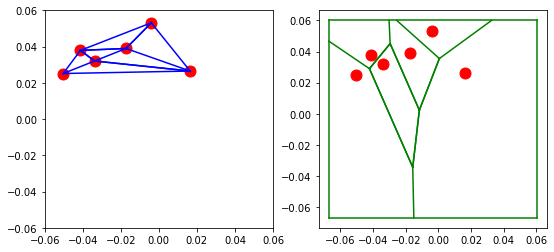

In [14]:
plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plot_points(points, 'ro', markersize=11)
plot_lines(lines, 'b-')
plt.xlim(-0.06, 0.06)
plt.ylim(-0.06, 0.06)

plt.subplot(1, 2, 2)
plot_points(points, 'ro', markersize=11)
plot_lines(dual_graph, 'g-')

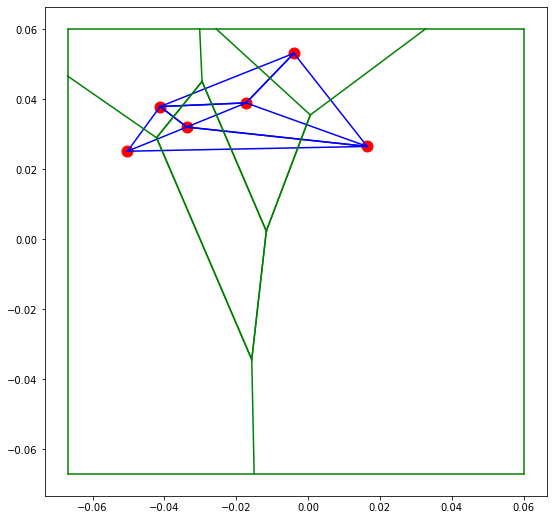

In [15]:
plt.figure(figsize=(9, 9))

plot_points(points, 'ro', markersize=11)
plot_lines(lines, 'b-')
plot_lines(dual_graph, 'g-')

Random points

In [16]:
def randomPoints(n, left, right):
    """Generate list of random points (testing purpose only).
    
    n: number of points
    left: left end for points
    right: right end for points
    
    returns: list of 2-tuples (x, y)
    """
    pts = []
    for i in range(0,n):
        pts.append((left + np.random.uniform(left, right), left + np.random.uniform(left, right)))
    return pts

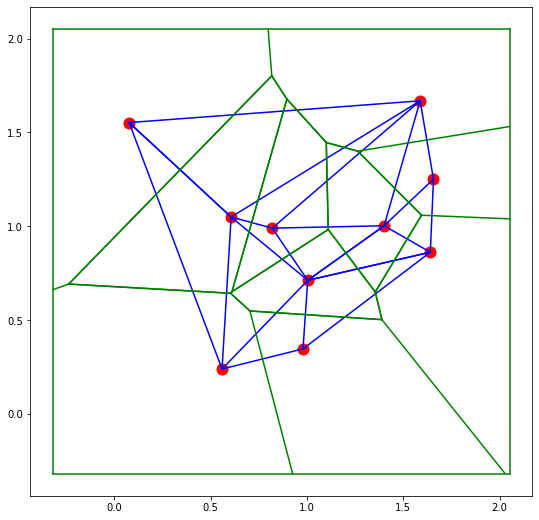

In [17]:
points2 = randomPoints(10, 0.0, 2.0)

T2, _ = delaunay_triangulation(points2)
lines2 = T2.lines()
dual_graph2 = make_dual_graph(T2.bfs_triangulation())


plt.figure(figsize=(9, 9))

plot_points(points2, 'ro', markersize=11)
plot_lines(lines2, 'b-')
plot_lines(dual_graph2, 'g-')

## Computation time

n:14703 / 15000,	done: 49 / 49

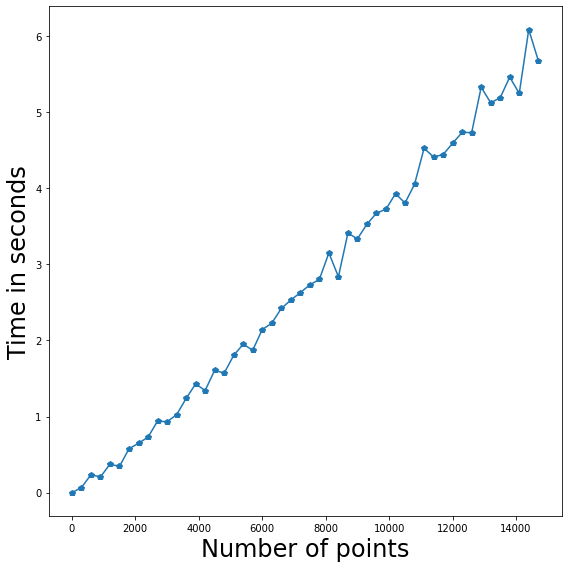

In [56]:
ns = []
times = []

end   = 15000
step  = 300
total = (end - 3)//step

for i, n in enumerate(range(3, end, step)):
    points = randomPoints(n, 0, 10)
    _, total_time = delaunay_triangulation(points)
    ns.append(n)
    times.append(total_time)
    print('\rn:{:=6} / {},\tdone:{:=3} / {}'.format(n, end, i, total), end='')

plt.figure(figsize=(8, 8))
plt.plot(ns, times, 'p-')
plt.xlabel('Number of points', fontsize=24)
plt.ylabel('Time in seconds', fontsize=24)
plt.tight_layout()

The time needed for computing a triangulation is supposed to be $\mathcal{O}(n\log n)$ and our algorithm seems to reach that performance.